In [68]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.models.cifar10.resnet import ResNet18
from torch.nn import functional as F

In [69]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [70]:
model = ResNet18(alpha=1).to(device)

model.load_state_dict(torch.load('./pretrained/resnet18_cifar10_gvp_model_10.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [71]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

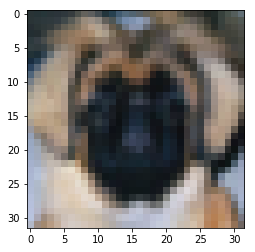

In [72]:
img_path = './test_img/cifar10/test1.png'

img = Image.open(img_path)

plt.imshow(img)

target_class = 8

In [73]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 32,32)

tensor_img = Variable(tensor_img, requires_grad=True)

In [74]:
gradients = None

def hook_function(module, grad_input, grad_output):
    global gradients
    
    gradients = grad_input[0]
    
first_layer = list(model._modules.items())[0][1]
first_layer.register_backward_hook(hook_function)

In [75]:
output = model(tensor_img).to(device)

In [76]:
model.zero_grad()

In [77]:
one_hot_output = torch.cuda.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target_class] = 1

In [78]:
output.backward(gradient=one_hot_output)

In [79]:
grad_img = gradients.cpu().data.numpy()[0]

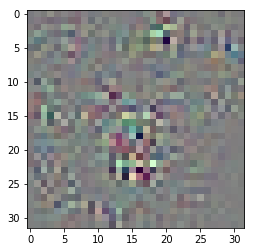

In [80]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

grad_img = scaling(grad_img)

grad_img = grad_img.transpose(1,2,0)

if np.max(grad_img) <= 1:
    grad_img = (grad_img*255).astype(np.uint8)
    
plt.imshow(grad_img)

In [81]:
grad_times_img = gradients.cpu().data.numpy()[0] + tensor_img.detach().cpu().numpy()[0]

In [82]:
grad_times_img.shape

(3, 32, 32)

In [83]:
def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [84]:
grad_times_img = convert_to_grayscale(grad_times_img)

In [85]:
grad_times_img = grad_times_img - grad_times_img.min()
grad_times_img /= grad_times_img.max()

In [86]:
grad_times_img.shape

(1, 32, 32)

In [87]:
grad_times_img = np.repeat(grad_times_img, 3, axis=0)

In [88]:
grad_times_img = grad_times_img.transpose(1,2,0)

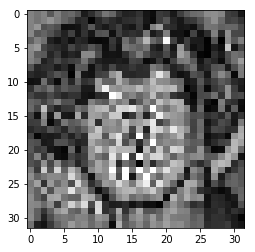

In [89]:
plt.imshow(grad_times_img)